In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [92]:
def load_file(f):
    df = pd.read_csv(f)
    return df

In [2]:
def load_data(sym="EUR", to_sym="USD", interval="5min", dtype=2, intraday=False, outputsize="full"):
    key = "ENTER_YOUR_KEY"
    if dtype == 1: # Download stock
        print("STOCKS")
        if intraday:
            url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&interval={}&symbol={}&apikey={}&datatype=csv&outputsize={}".format(interval, sym, key, outputsize)
        else:
            url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&apikey={}&datatype=csv&outputsize={}".format(sym, key, outputsize)
    elif dtype == 2: # Download forex
        print("FX")
        if intraday:
            url = "https://www.alphavantage.co/query?function=FX_INTRADAY&interval={}&from_symbol={}&to_symbol={}&apikey={}&datatype=csv&outputsize={}".format(interval, sym, to_sym, key, outputsize)
        else:
            url = "https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={}&to_symbol={}&apikey={}&datatype=csv&outputsize={}".format(sym, to_sym, key, outputsize)
    elif dtype == 3: # Download Crypto
        print("CRYPTO")
        url = "https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={}&market={}&apikey={}&datatype=csv&outputsize={}".format(sym, to_sym, key, outputsize)
    print("Downloading", url)
    print("---")
    df = pd.read_csv(url)

    # rename columns
    if dtype == 3:
        df.rename(columns={'timestamp': 'Date', 'open (USD)': 'Open', 'high (USD)': 'High', 'low (USD)': 'Low', 'close (USD)': 'Close', 'volume': 'Volume'}, inplace=True)
    else:
        df.rename(columns={'timestamp': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    df.sort_values(by="Date", ascending=True, inplace=True)
    print("Data loaded:", len(df), "rows")
    return df.reset_index(drop=True)

In [249]:
def plot_candles(sym, df, db, lines=100, wicks=True):
    """
    sym: symbol
    df: daily data
    db: random out-of-sample data
    lines: plot last n lines
    """
    # Bar heights
    df['Bar'] = df['High'] - df['Low']
    # Body heights
    df['Body'] = abs(df['Close'] - df['Open'])
    # Up or Down bar?
    df['Up'] = df['Close'] > df['Open']
    # Green if up else Red
    df['Color'] = np.where(df['Up'], "#27AE60", "#C0392B")
    # do the same for daily data
    db['Bar'] = db['High'] - db['Low']
    db['Body'] = abs(db['Close'] - db['Open'])
    db['Up'] = db['Close'] > db['Open']
    db['Color'] = np.where(db['Up'], "#7DCEA0", "#D98880")
    if lines > 0:
        db1 = df[-lines:].reset_index(drop=True).reset_index()
    else:
        db1 = df.reset_index(drop=True).reset_index()
    idx = list(np.array(np.arange(len(db1) , len(db1) + len(db))))
    db["index"] = idx
    db = db.reset_index(drop=True).reset_index()
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    ax.yaxis.tick_right()
    ax.axvline(idx[0], ls="-.", color="#000000", linewidth=0.5)
    ax.text(0.01, 0.95, "Historical Data", transform=plt.gca().transAxes, size=20, horizontalalignment="left")
    ax.text(0.99, 0.95, "OOS Data", transform=plt.gca().transAxes, size=20, horizontalalignment="right")
    if wicks:
        ax.bar(db1['index'], bottom=db1['Low'], height=db1['Bar'], color="#000000", width=0.2)
    ax.bar(db1['index'], bottom=np.where(db1['Up'], db1['Open'], db1['Close']), height=db1['Body'], color=db1['Color'], width=0.9)
    if wicks:
        ax.bar(db['index'], bottom=db['Low'], height=db['Bar'], color="#566573", width=0.2)
    ax.bar(db['index'], bottom=np.where(db['Up'], db['Open'], db['Close']), height=db['Body'], color=db['Color'], width=0.9)
    plt.title(sym + " CHART")
    plt.show()

In [134]:
def out_of_sample_ohlc(df, daily, days=30, bars=24, level=1, seed=-1):
    """
    df: intraday DataFrame
    daily: daily DataFrame
    days: How many days to create? Out of sample size
    bars: How many bars in a day? 24 if you are using hourly data
    level: strength of the distribution
    seed: if seed >= 0, we will get random data each time
    """
    if seed >= 0:
        np.random.seed(seed)
    # set intraday returns between bars
    df["Returns"] = df["Close"] / df["Open"].shift(1)
    # set daily gaps between days
    daily["Gaps"] = daily["Open"] / daily["Close"].shift(1)
    df = df.dropna()
    daily = daily.dropna()
    # calculate standard deviation and mean of Returns
    std, mn = np.std(df["Returns"]), np.mean(df["Returns"])
    # calculate standard deviation and mean of Returns
    std_gap, mn_gap = np.std(daily["Gaps"]), np.mean(daily["Gaps"])
    # let's create normal distribution data from Returns and Gaps
    returns = np.random.normal(mn, std, len(df) * level)
    gaps = np.random.normal(mn_gap, std_gap, len(daily) * level)
    ohlc = []
    # Get the last days closing price
    c = daily["Close"].iloc[-1]
    for d in range(days):
        # select a random gap. you can use np.random.choice() if you wish
        rnd = np.random.randint(len(gaps))
        # if there's gap, add it
        c = c * gaps[rnd]
        # all values are equal at the start of day
        o = c
        h = c
        l = c
        # simulate closing price for each bar (selected time-frame)
        for b in range(bars):
            # select a random return. you can use np.random.choice() if you wish
            rnd = np.random.randint(len(returns))
            c = o * returns[rnd]
            if c > h:
                h = c
            if c < l:
                l = c
        ohlc.append([o, h, l, c])
    return ohlc

In [198]:
# Settings
sym = "SPY"
to_sym = "USD" # Forex & Crypto only
interval = "15min" # intraday only - 1min, 5min, 15min, 30min, 60min
intraday = True # False = Daily
dtype = 1 # 1: stock 2: fx 3: crypto

df = load_data(sym, to_sym, interval, dtype, intraday)
# we also get the daily data
daily = load_data(sym, to_sym, interval, dtype, intraday=False)

STOCKS
---
Data loaded: 780 rows
STOCKS
---
Data loaded: 5033 rows


In [199]:
df.tail()

,Date,Open,High,Low,Close,Volume
775,2020-05-01 15:00:00,282.400,282.64,282.03,282.570,1731625
776,2020-05-01 15:15:00,282.560,283.24,282.25,283.130,2569081
777,2020-05-01 15:30:00,283.130,283.40,282.52,282.715,2741136
778,2020-05-01 15:45:00,282.715,282.94,282.12,282.540,4314263
779,2020-05-01 16:00:00,282.550,283.05,281.83,282.760,12925213


In [244]:
# how many out of sample data do we need?
days = 50
# Stock market is opened 6.5 hours (390 minutes) every day. We need to consider this
# There are twenty-six 15min bars in a day (for stocks market)
bars = 26
digit = 2 # 2 for stocks, 5 for FX, 3 for XXXJPY, 8 for Crypto
seed = 100 # if below zero, generates random data each time
ohlc = out_of_sample_ohlc(df, daily, bars=bars, days=days, seed=seed, level=1000)
db = pd.DataFrame(columns=["Open", "High", "Low", "Close"], data=np.array(np.round(ohlc, digit)))
db.tail(10)

,Open,High,Low,Close
40,294.32,300.19,290.18,296.62
41,297.37,300.89,293.09,297.90
42,297.08,301.13,292.54,297.50
43,297.22,302.31,293.44,299.34
44,301.57,307.02,296.92,299.84
45,299.93,305.14,295.53,298.66
46,301.89,306.34,297.65,300.11
47,299.07,303.17,294.36,298.74
48,303.22,307.82,296.29,302.68
49,304.39,309.66,299.10,303.40


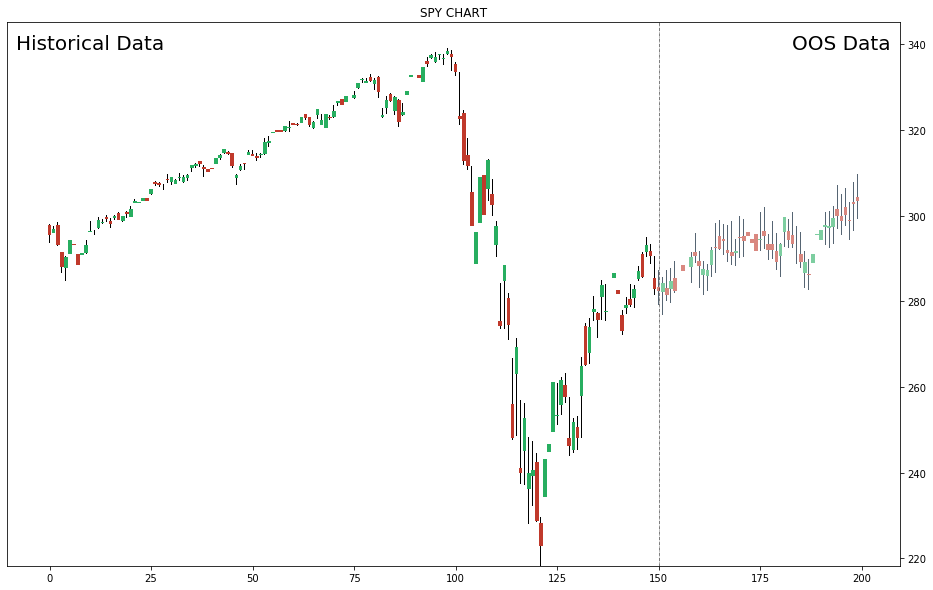

In [253]:
plot_candles(sym, daily, db, lines=150, wicks=True)